Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0737 - val_loss: 0.0285
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0336 - val_loss: 0.0252
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0307 - val_loss: 0.0240
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0293 - val_loss: 0.0231
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0286 - val_loss: 0.0230
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0280 - val_loss: 0.0222
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0277 - val_loss: 0.0219
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0273 - val_loss: 0.0218
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0268 - val_loss: 0.0213
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0267 - val_loss: 0.0212
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0264 - val_loss: 0.0210
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━

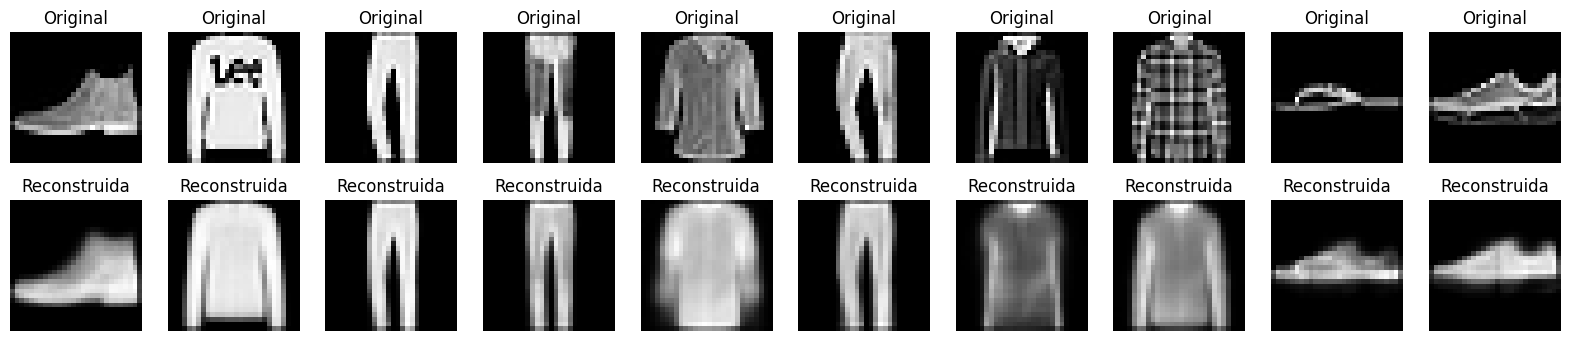

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


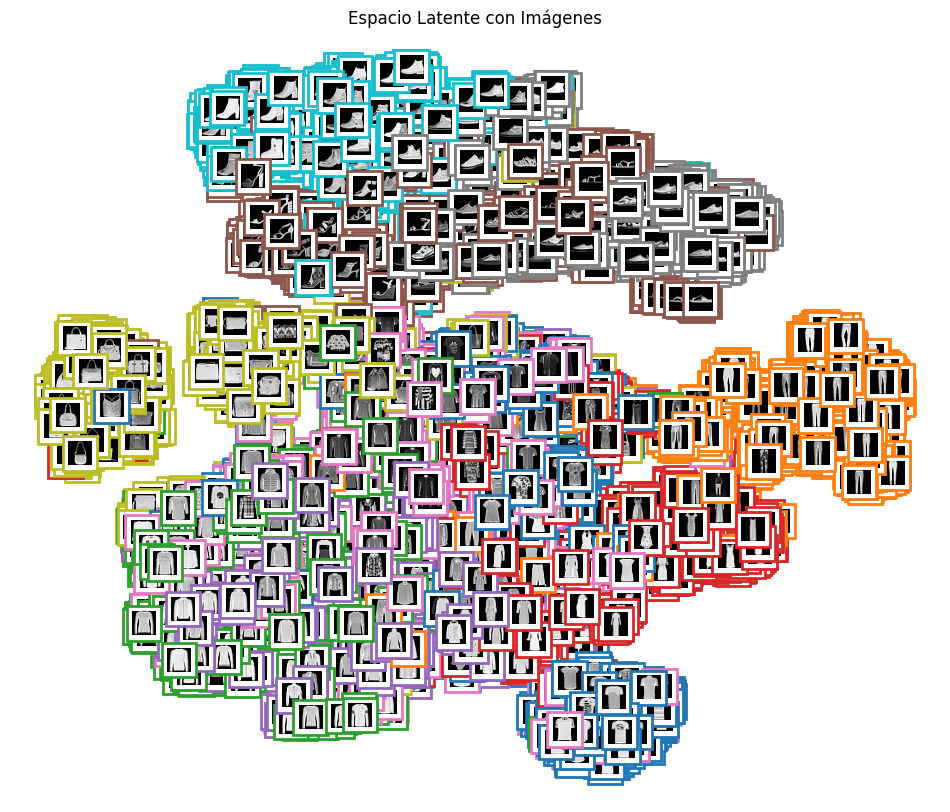

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from keras.datasets import fashion_mnist
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# ----------------------------------------------------------------------
# Cargar y preprocesar los datos de Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalizar los valores de píxeles a [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Aplanar las imágenes para que sean de tamaño 784 (28*28)
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

# ----------------------------------------------------------------------
# Definir el autoencoder utilizando dos capas densas con Dropout en el encoder y decoder

# Parámetros del modelo
input_shape = 784  # 28 * 28
latent_dim = 16    # Dimensión del espacio latente

# Definir el codificador (encoder)
encoder_input = layers.Input(shape=(input_shape,))
x = layers.Dense(256, activation='relu')(encoder_input)
x = layers.Dropout(0.3)(x)  # Dropout después de la primera capa densa
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)  # Dropout después de la segunda capa densa
latent = layers.Dense(latent_dim, activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4))(x)

# Definir el decodificador (decoder)
x = layers.Dense(128, activation='relu')(latent)
x = layers.Dropout(0.3)(x)  # Dropout después de la primera capa densa en el decoder
x = layers.Dropout(0.3)(x)  # Dropout después de la segunda capa densa en el decoder
decoder_output = layers.Dense(input_shape, activation='sigmoid')(x)

# Definir el modelo autoencoder completo
autoencoder = models.Model(encoder_input, decoder_output)

# ----------------------------------------------------------------------
# Compilar el modelo usando cross-entropy como función de costo
autoencoder.compile(optimizer='adam', loss='mse') #binary_crossentropy

# Entrenar el modelo
autoencoder.fit(x_train, x_train, epochs=20, batch_size=128, validation_data=(x_test, x_test))

# ----------------------------------------------------------------------
# Visualización de las imágenes reconstruidas

# Reconstruir las imágenes de prueba
decoded_imgs = autoencoder.predict(x_test)

# Mostrar las imágenes originales y reconstruidas
n = 10  # Número de imágenes a mostrar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Imagen reconstruida
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstruida")
    plt.axis('off')
plt.show()

# ----------------------------------------------------------------------
# Visualización del espacio latente con imágenes

# Definir un modelo solo con el codificador para extraer el espacio latente
encoder = models.Model(inputs=autoencoder.input, outputs=latent)

# Extraer el espacio latente para las imágenes de prueba
latent_space = encoder.predict(x_test)

# Reducir la dimensionalidad del espacio latente a 2D para visualización (usando t-SNE)
latent_2d = TSNE(n_components=2).fit_transform(latent_space)

# Función para agregar imágenes en las posiciones correspondientes
def plot_latent_images(latent_2d, x_test, y_test, threshold=0.05):
    fig, ax = plt.subplots(figsize=(12, 10))
    cmap = plt.cm.tab10
    ax.scatter(latent_2d[:, 0], latent_2d[:, 1], c=y_test, s=10, cmap=cmap)
    image_positions = np.array([[1., 1.]])

    for index, position in enumerate(latent_2d):
        dist = np.sum((position - image_positions) ** 2, axis=1)
        if np.min(dist) > threshold:  # Ajusta el umbral según sea necesario
            image_positions = np.r_[image_positions, [position]]
            imagebox = OffsetImage(x_test[index].reshape(28, 28), cmap="gray", zoom=0.6)
            ab = AnnotationBbox(imagebox, position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2})
            ax.add_artist(ab)

    plt.title('Espacio Latente con Imágenes')
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.axis('off')
    plt.show()

# Llamar a la función para visualizar las imágenes en el espacio latente
plot_latent_images(latent_2d, x_test, y_test)
